In [ ]:
# Cell 1: Setup & Reproducibility
# ==========================================
# Objective: Initialize libraries and set random seeds for consistent results.
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import joblib
import os
import random
import warnings
from category_encoders import TargetEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# REPRODUCIBILITY SETUP
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✅Libraries Loaded & Random Seed Set.")

✅Libraries Loaded & Random Seed Set.


In [8]:
# Cell 2: Data Loading & Cleaning Functions
# ==========================================
# Objective: Define functions to handle messy currency strings ($12,000) and load data.
# ==========================================

def clean_currency(x):
    """
    Converts string currency (e.g., '$12,000 ') to float (12000.0).
    Returns 0.0 if the value is missing or invalid.
    """
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', '').strip())
    return float(x) if pd.notnull(x) else 0.0

# Load the Dataset (Ensure 'diabetic_data.csv' is replaced with your actual SBA file name)
# Note: Using 'low_memory=False' because the dataset is large
print("🚀 Loading Dataset...")
# REPLACE 'SBAnational.csv' WITH YOUR ACTUAL FILE NAME
df = pd.read_csv('SBAnational.csv', low_memory=False)

print(f"✅ Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

🚀 Loading Dataset...
✅ Data Loaded: 899164 rows, 27 columns


In [9]:
# Cell 3: Preprocessing & Target Engineering
# ==========================================
# Objective: Create the binary target variable and handle missing values.
# ==========================================

print("🛠️ Starting Preprocessing...")

# 1. Target Creation: MIS_Status
# 'P I F' = 0 (Paid in Full), 'CHGOFF' = 1 (Default)
df = df.dropna(subset=['MIS_Status'])
df['target'] = df['MIS_Status'].map({'P I F': 0, 'CHGOFF': 1})

# 2. Currency Cleaning
currency_cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv', 'BalanceGross']
for col in currency_cols:
    df[col] = df[col].apply(clean_currency)

# 3. Handling Nulls (The "Senior" Way)
# Instead of dropping everything, we fill categorical nulls with "Unknown" to preserve data
cat_cols = ['NewExist', 'RevLineCr', 'LowDoc', 'City', 'State', 'BankState']
for col in cat_cols:
    df[col] = df[col].fillna('Unknown').astype(str)

# Drop rows where 'DisbursementDate' is missing (needed for Time Series Split)
df = df.dropna(subset=['DisbursementDate'])

print(f"✅ Preprocessing Complete. Final shape: {df.shape}")
print(f"⚠️ Default Rate: {df['target'].mean():.2%}")

🛠️ Starting Preprocessing...
✅ Preprocessing Complete. Final shape: (894992, 28)
⚠️ Default Rate: 17.57%


In [10]:
# Cell 4: Feature Engineering & Time-Series Split
# ==========================================
# Objective: Sort data by date and split the LAST 20% for testing.
# ==========================================

print("⏳ Performing Time-Series Split...")

# 1. Convert Date Column
df['DisbursementDate'] = pd.to_datetime(df['DisbursementDate'], errors='coerce')
df = df.sort_values('DisbursementDate')  # CRITICAL: Sort by date!

# 2. Select Features
features = [
    'State', 'BankState', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
    'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc',
    'GrAppv', 'SBA_Appv'
]

X = df[features]
y = df['target']

# 3. Manual Time-Series Split (80% Train, 20% Test)
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"✅ Train Set: {X_train.shape[0]} loans (Past)")
print(f"✅ Test Set:  {X_test.shape[0]} loans (Future)")

⏳ Performing Time-Series Split...
✅ Train Set: 715993 loans (Past)
✅ Test Set:  178999 loans (Future)


In [13]:
# Cell 5 (UPGRADED): Ensemble Modeling
# ==========================================
# Objective: Stack XGBoost and LightGBM for maximum stability.
# ==========================================

from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

print("🤖 Training Ensemble Model (XGBoost + LightGBM)...")

# 1. Target Encoding (Same as before)
# Add 'NewExist' to the columns to be target encoded, as it's an 'object' type.
encoder = TargetEncoder(cols=['State', 'BankState', 'RevLineCr', 'LowDoc', 'NewExist'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# 2. Define Solvers
# Scale Pos Weight for Imbalance
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 3. Soft Voting Ensemble
# 'Soft' voting averages the probabilities of both models
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft'
)

ensemble_model.fit(X_train_encoded, y_train)
print("✅ Ensemble Model Trained Successfully.")

🤖 Training Ensemble Model (XGBoost + LightGBM)...
✅ Ensemble Model Trained Successfully.


🧐 Generating SHAP Explanations...


PermutationExplainer explainer: 1001it [13:51,  1.20it/s]


<Figure size 1000x600 with 0 Axes>

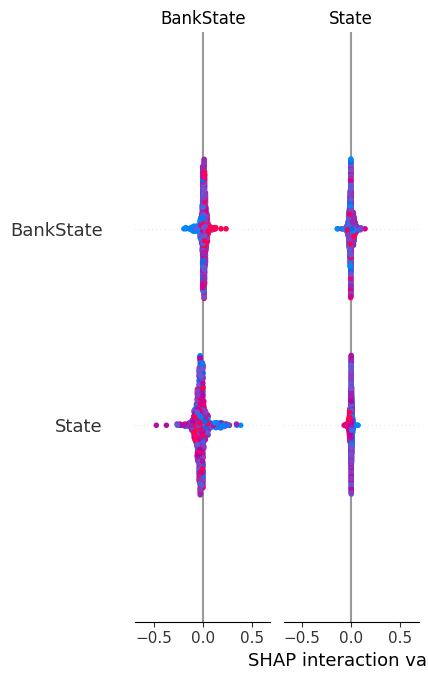

In [20]:
# Cell 7: SHAP Interpretation
# ==========================================
# Objective: Explain the model decisions using SHAP values.
# ==========================================

print("🧐 Generating SHAP Explanations...")

explainer = shap.Explainer(ensemble_model.predict_proba, X_train_encoded)
# Use a smaller sample for speed (first 1000 rows)
shap_values = explainer(X_test_encoded.iloc[:1000])

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_encoded.iloc[:1000], show=False)
plt.savefig('../images/shap_summary.png') # Autosave for README
plt.show()

🚀 ROC-AUC Score: 0.9515


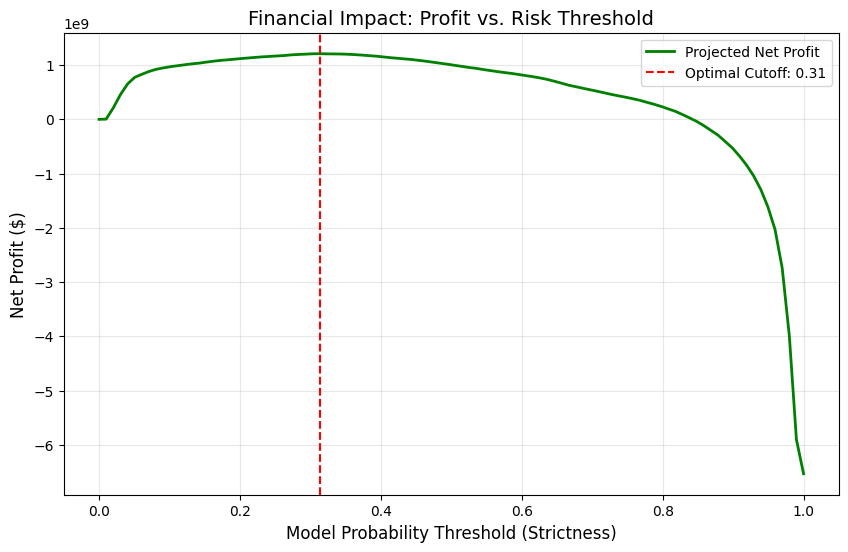

💰 Max Projected Profit: $1,209,525,000
🎯 Optimal Threshold: 0.31


In [17]:
# Cell 6: Evaluation & Profit Optimization Curve
# ==========================================
# Objective: Calculate Financial ROI and plot the Profit Curve.
# ==========================================

# 1. Standard Predictions
y_prob = ensemble_model.predict_proba(X_test_encoded)[:, 1]
print(f"🚀 ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 2. DEFINE THE PROFIT FUNCTION
# Assumption: Average Loan = $150k. Interest Margin = 10%.
# - True Positive (Reject Bad Loan): $0 Saved (Neutral)
# - False Negative (Approve Bad Loan): -$150,000 Loss
# - True Negative (Approve Good Loan): +$15,000 Profit
# - False Positive (Reject Good Loan): -$15,000 Opportunity Cost

def calculate_profit(y_true, y_pred_prob, threshold):
    avg_loan = 150000
    interest_rate = 0.10
    profit_per_good_loan = avg_loan * interest_rate
    loss_per_bad_loan = avg_loan

    decisions = (y_pred_prob >= threshold).astype(int) # 1=Default (Reject), 0=Pay (Approve)

    # Inverted Logic: Model predicts '1' (Default). So we REJECT if prob > threshold.
    # We make money on Approvals (0s) that are actually Good (0s).

    tp = np.sum((decisions == 1) & (y_true == 1)) # Correctly Rejected Bad Loan (Saved Money)
    fp = np.sum((decisions == 1) & (y_true == 0)) # Incorrectly Rejected Good Loan (Lost Opportunity)
    tn = np.sum((decisions == 0) & (y_true == 0)) # Correctly Approved Good Loan (Made Profit)
    fn = np.sum((decisions == 0) & (y_true == 1)) # Incorrectly Approved Bad Loan (Lost Money)

    total_profit = (tn * profit_per_good_loan) - (fn * loss_per_bad_loan)
    return total_profit

# 3. Sweep Thresholds to find the best one
thresholds = np.linspace(0, 1, 100)
profits = [calculate_profit(y_test, y_prob, t) for t in thresholds]

optimal_threshold = thresholds[np.argmax(profits)]
max_profit = max(profits)

# 4. PLOT THE CURVE

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label='Projected Net Profit', color='green', linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Cutoff: {optimal_threshold:.2f}')
plt.title('Financial Impact: Profit vs. Risk Threshold', fontsize=14)
plt.xlabel('Model Probability Threshold (Strictness)', fontsize=12)
plt.ylabel('Net Profit ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Ensure the directory exists before saving
os.makedirs('../images', exist_ok=True)
plt.savefig('../images/profit_curve.png') # Autosave for README
plt.show()

print(f"💰 Max Projected Profit: ${max_profit:,.0f}")
print(f"🎯 Optimal Threshold: {optimal_threshold:.2f}")

In [26]:
# Cell 9: Save Model Assets (Colab Compatible)
# ==========================================
# Objective: Save the trained model locally in Colab so you can download it.
# ==========================================

# 1. Create a folder named 'models' inside the current Colab session
os.makedirs('models', exist_ok=True)

# 2. Save the files inside that folder
print("💾 Saving models...")
joblib.dump(ensemble_model, 'models/sba_risk_model.pkl')
joblib.dump(encoder, 'models/sba_encoder.pkl')

print("✅ Saved! Click the Folder Icon 📁 on the left sidebar to download them.")

💾 Saving models...
✅ Saved! Click the Folder Icon 📁 on the left sidebar to download them.


⚖️ Running Fairness Audit...


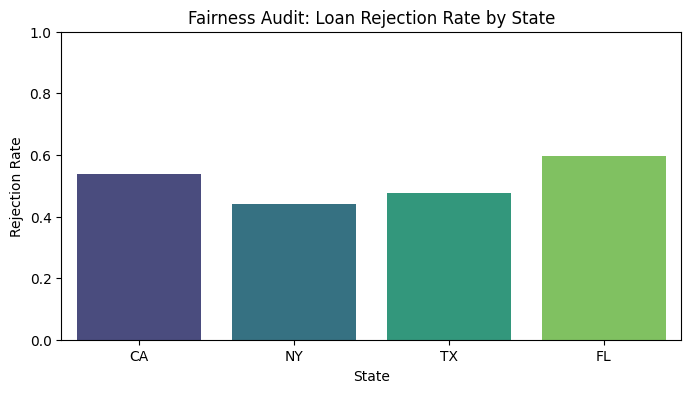

  State  Rejection Rate  Model Accuracy  Count
0    CA        0.537447        0.884087  23647
1    NY        0.441399        0.868977  13242
2    TX        0.477334        0.808765  12618
3    FL        0.595122        0.876335   9267


In [21]:
# Cell 8 (NEW): Geographic Fairness Audit
# ==========================================
# Objective: Ensure the model treats CA (California) and NY (New York) fairly.
# ==========================================

print("⚖️ Running Fairness Audit...")

# Attach predictions back to the test set for analysis
audit_df = X_test.copy()
audit_df['Actual_Default'] = y_test
audit_df['Pred_Prob'] = ensemble_model.predict_proba(X_test_encoded)[:, 1] # Use 'model' if not using ensemble
audit_df['Pred_Reject'] = (audit_df['Pred_Prob'] > optimal_threshold).astype(int)

# Define a Metric: "Rejection Rate" (How often do we say NO?)
# If NY has 90% rejection and CA has 10%, we might have a bias problem.

states_to_audit = ['CA', 'NY', 'TX', 'FL']
bias_report = []

for state in states_to_audit:
    state_data = audit_df[audit_df['State'] == state]
    rejection_rate = state_data['Pred_Reject'].mean()
    accuracy = (state_data['Actual_Default'] == state_data['Pred_Reject']).mean()

    bias_report.append({
        'State': state,
        'Rejection Rate': rejection_rate,
        'Model Accuracy': accuracy,
        'Count': len(state_data)
    })

bias_df = pd.DataFrame(bias_report)

# Visualize
plt.figure(figsize=(8, 4))
sns.barplot(data=bias_df, x='State', y='Rejection Rate', palette='viridis')
plt.title('Fairness Audit: Loan Rejection Rate by State')
plt.ylim(0, 1)
plt.show()

print(bias_df)